In [1]:
import os
import numpy as np
import random as rd
import pandas as pd
import seaborn as sns
import category_encoders as ce
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
file_path = "C:/Users/Amith Nandivada/Desktop/Amith/MS/CUB/Boulder Course Material/Fall23/Machine Learning/Assignment/Data/cleaned_data.csv"

property_df = pd.read_csv(file_path)
print(property_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5147 entries, 0 to 5146
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   grosssize               5147 non-null   float64
 1   grosssizeadjusted       5147 non-null   float64
 2   groundfloorsize         5147 non-null   float64
 3   livingsize              5147 non-null   float64
 4   baths_full              5147 non-null   float64
 5   bed                     5147 non-null   float64
 6   rooms_total             5147 non-null   float64
 7   prkgSize                5147 non-null   float64
 8   assdImprValue           5147 non-null   float64
 9   assdTtlValue            5147 non-null   float64
 10  mktTtlValue             5147 non-null   float64
 11  taxAmt                  5147 non-null   float64
 12  baths_total_calculated  5147 non-null   float64
 13  property_type           5147 non-null   object 
 14  propsubtype             5147 non-null   

In [4]:
property_df["saleAmt"].isna().sum()

0

## Analysis on Numerical Columns

In [5]:
num_cols = property_df.columns[property_df.dtypes != 'object']
num_cols

Index(['grosssize', 'grosssizeadjusted', 'groundfloorsize', 'livingsize', 'baths_full', 'bed', 'rooms_total', 'prkgSize', 'assdImprValue', 'assdTtlValue', 'mktTtlValue', 'taxAmt', 'baths_total_calculated', 'saleAmt'], dtype='object')

                        grosssize  grosssizeadjusted  groundfloorsize  livingsize  baths_full       bed  rooms_total  prkgSize  assdImprValue  assdTtlValue  mktTtlValue    taxAmt  baths_total_calculated   saleAmt
grosssize                1.000000           0.896528         0.690753    0.896528    0.835456  0.835372     0.833507  0.710143       0.883569      0.719979     0.928322  0.572051                0.839459  0.625616
grosssizeadjusted        0.896528           1.000000         0.769958    1.000000    0.786014  0.781377     0.803072  0.618865       0.807541      0.674744     0.834644  0.563033                0.788501  0.570158
groundfloorsize          0.690753           0.769958         1.000000    0.769958    0.482065  0.498206     0.520007  0.421543       0.755576      0.897230     0.706748  0.835645                0.481082  0.525732
livingsize               0.896528           1.000000         0.769958    1.000000    0.786014  0.781377     0.803072  0.618865       0.807541      0

<AxesSubplot:>

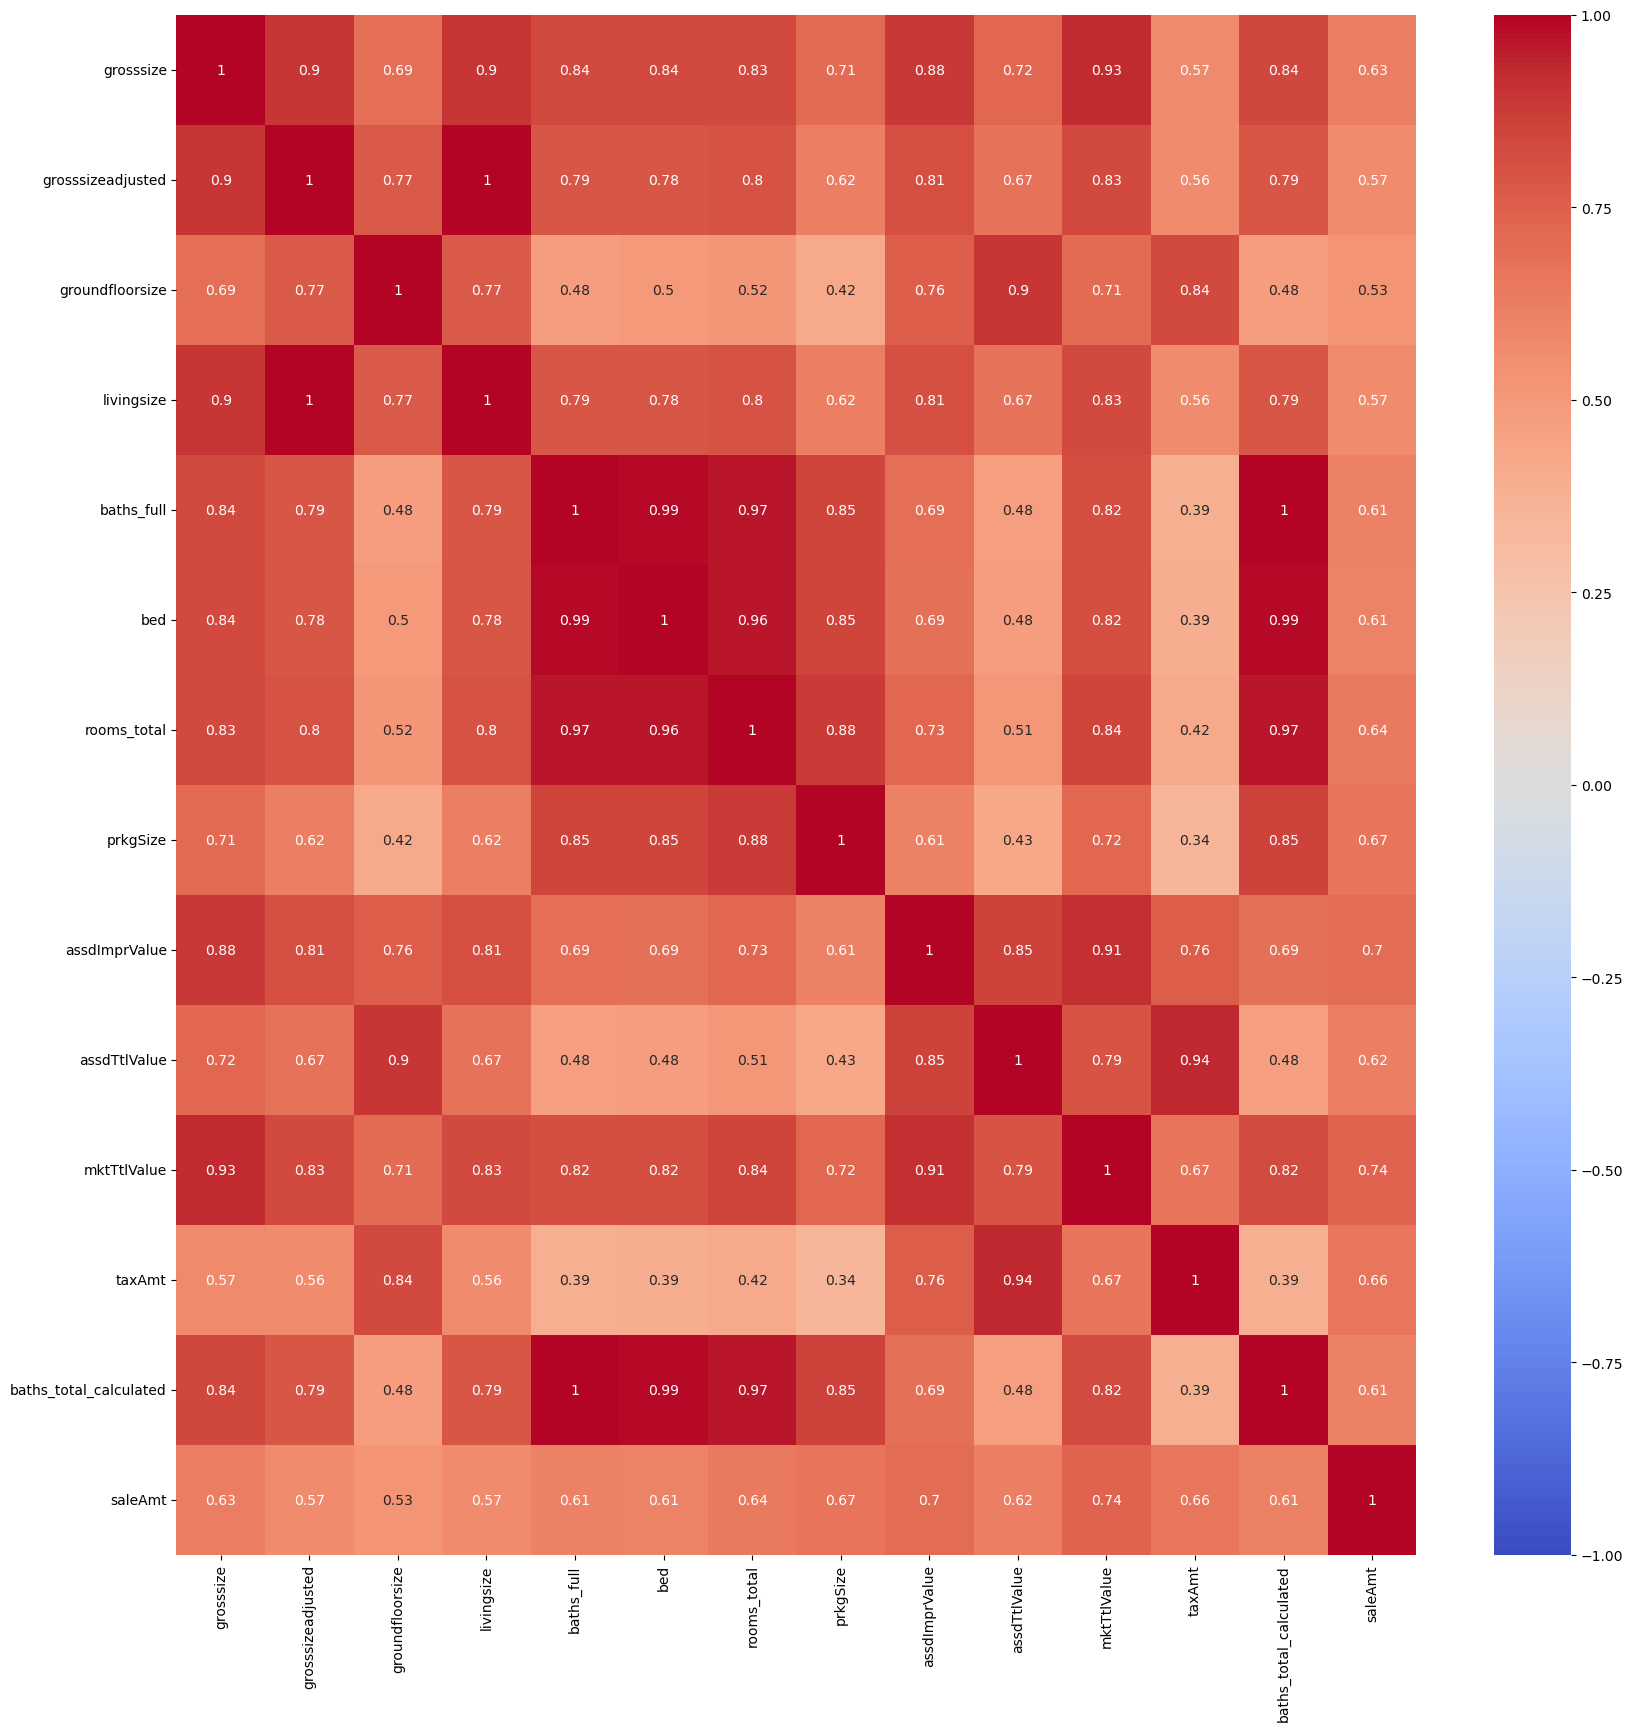

In [76]:
num_cols = [x for x in num_cols if x != 'saleAmt'] + ['saleAmt']
corr = property_df[num_cols].corr()
print(corr)

plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

## Analysis on Categorical Columns

In [7]:
property_df.describe(include='O')

,property_type,propsubtype,proptype,heatingtype,coolingtype,wallType,saleRecDate,condition,constructiontype,frameType,prkgType,bldgType
count,5147,5147,5147,5147,5147,5147,5147,5147,5147,5147,5147,5147
unique,30,7,29,10,6,12,2930,5,11,5,6,4
top,SINGLE FAMILY RESIDENCE,RESIDENTIAL,SFR,FORCED AIR,CENTRAL,BRICK VENEER,2005-03-04,AVERAGE,FRAME,WOOD,"Garage, Attached",CONVENTIONAL HOUSE
freq,2479,4978,2556,4239,2835,2421,33,2674,3195,3267,3361,2981


## Convert Required Categorical Columns to Numerical Columns for SVM

In [8]:
data = property_df

# Define a significance level (alpha) for the ANOVA test
alpha = 0.05

# Initialize a list to store columns with significant dependency
significant_cols = []

# Iterate through categorical columns
categorical_columns = data.columns[property_df.dtypes == 'object']
# categorical_columns = ['property_type', 'absenteeInd', 'heatingtype', 'coolingtype', 'wallType', 'saleTransType', 'condition', 'constructiontype', 'frameType', 'prkgType', 'bldgType']

for column in categorical_columns:
    # Perform ANOVA test for independence
    groups = [data[data[column] == category]['saleAmt'] for category in data[column].unique()]
    f_statistic, p_value = f_oneway(*groups)
    
    # Check if the p-value is less than alpha (indicating significant dependency)
    if p_value < alpha:
        significant_cols.append(column)

# Select only the significant columns from the dataset
data_filtered = data[significant_cols + ['saleAmt']]

# Perform target encoding for the selected columns
encoder = ce.TargetEncoder()
data_encoded = encoder.fit_transform(data_filtered.drop('saleAmt', axis=1), data_filtered['saleAmt'])

# Combine the encoded data with the original 'saleAmt' column
property_df_encoded = pd.concat([data_encoded, data_filtered['saleAmt']], axis=1)

property_df_encoded.head(5)

,property_type,propsubtype,proptype,heatingtype,coolingtype,wallType,saleRecDate,condition,constructiontype,frameType,prkgType,bldgType,saleAmt
0,796241.217426,691279.568903,803463.734742,677479.963671,704002.031041,850453.637753,713242.190135,6.061591e+05,685772.730203,741104.830425,603424.419521,2.399808e+06,501930.0
1,393683.553323,691279.568903,393683.553323,677479.963671,701893.005226,828838.765778,676663.905204,6.061591e+05,685772.730203,741104.830425,786176.916989,6.092664e+05,179350.0
2,796241.217426,691279.568903,803463.734742,677479.963671,704002.031041,850453.637753,792087.341937,7.907225e+05,685772.730203,741104.830425,786176.916989,7.643636e+05,1900000.0
3,796241.217426,691279.568903,803463.734742,677479.963671,704002.031041,850453.637753,832184.472070,6.061591e+05,744620.611224,744620.611224,786176.916989,7.643636e+05,1100000.0
4,796241.217426,691279.568903,803463.734742,677479.963671,704002.031041,850453.637753,751763.406140,1.201011e+06,744620.611224,744620.611224,786176.916989,7.643636e+05,798000.0


In [9]:
# Drop categorical columns in property_df
property_df = property_df.select_dtypes(exclude=['object'])

# Merge the encoded categorical columns data to property_df
property_df = pd.concat([property_df, property_df_encoded.drop('saleAmt', axis=1)], axis=1)
property_df.describe(include='all')

,grosssize,grosssizeadjusted,groundfloorsize,livingsize,baths_full,bed,rooms_total,prkgSize,assdImprValue,assdTtlValue,mktTtlValue,taxAmt,baths_total_calculated,saleAmt,property_type,propsubtype,proptype,heatingtype,coolingtype,wallType,saleRecDate,condition,constructiontype,frameType,prkgType,bldgType
count,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5.147000e+03,5.147000e+03,5.147000e+03,5147.000000,5147.000000,5.147000e+03,5.147000e+03,5.147000e+03,5.147000e+03,5.147000e+03,5.147000e+03,5.147000e+03,5.147000e+03,5.147000e+03,5.147000e+03,5.147000e+03,5147.000000,5.147000e+03
mean,2909.412862,1982.077132,1647.700818,1982.077132,2.071304,3.543423,7.492326,495.264846,4.645036e+04,7.128977e+04,8.490291e+05,6541.914312,2.944822,7.448479e+05,6.912288e+05,7.392740e+05,6.912433e+05,7.417029e+05,7.399729e+05,7.379896e+05,7.480519e+05,7.448770e+05,7.309487e+05,7.403743e+05,744761.478359,7.450742e+05
std,8699.439421,5067.840521,4284.518558,5067.840521,13.268863,13.558907,24.028648,1172.644111,1.561694e+05,2.439678e+05,2.115490e+06,21363.092294,13.268904,2.353568e+06,7.706794e+05,2.981515e+05,7.701445e+05,3.000136e+05,2.531116e+05,1.853134e+05,2.866732e+05,2.363256e+05,2.549569e+05,7.295949e+04,118516.285610,2.788011e+05
min,90.000000,90.000000,8.000000,90.000000,0.000000,1.000000,1.000000,86.000000,2.900000e+02,3.430000e+02,1.300000e+03,33.840000,0.000000,5.000000e+02,3.936836e+05,6.912796e+05,3.936836e+05,5.515735e+05,7.018930e+05,5.245341e+05,5.162916e+05,6.061591e+05,6.097213e+05,6.275322e+05,392588.149215,6.092664e+05
25%,1027.500000,970.000000,857.000000,970.000000,1.000000,2.000000,5.000000,260.000000,1.972400e+04,2.889500e+04,4.086000e+05,2713.380000,2.000000,3.290000e+05,3.936836e+05,6.912796e+05,3.936836e+05,6.774800e+05,7.018930e+05,5.245341e+05,6.920765e+05,6.061591e+05,6.857727e+05,7.411048e+05,786176.916989,6.092664e+05
50%,1938.000000,1312.000000,1121.000000,1312.000000,1.000000,3.000000,6.000000,480.000000,2.725100e+04,4.545300e+04,6.459000e+05,4257.880000,2.000000,4.980000e+05,7.962412e+05,6.912796e+05,8.034637e+05,6.774800e+05,7.040020e+05,8.288388e+05,7.159185e+05,6.061591e+05,6.857727e+05,7.411048e+05,786176.916989,7.643636e+05
75%,3214.500000,2006.500000,1592.000000,2006.500000,2.000000,4.000000,8.000000,506.000000,3.926400e+04,6.301250e+04,8.931500e+05,5956.320000,3.000000,7.600000e+05,7.962412e+05,6.912796e+05,8.034637e+05,6.774800e+05,7.040020e+05,8.504536e+05,7.502952e+05,7.907225e+05,7.446206e+05,7.446206e+05,786176.916989,7.643636e+05
max,362967.000000,165530.000000,172081.000000,165530.000000,518.000000,518.000000,966.000000,50626.000000,5.077697e+06,1.120128e+07,7.809005e+07,982413.360000,518.000000,1.042500e+08,9.974938e+06,3.182450e+06,9.974938e+06,2.836450e+06,2.599094e+06,2.113130e+06,1.421175e+07,1.968083e+06,3.231621e+06,1.590885e+06,869456.297873,2.399808e+06


In [10]:
property_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5147 entries, 0 to 5146
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   grosssize               5147 non-null   float64
 1   grosssizeadjusted       5147 non-null   float64
 2   groundfloorsize         5147 non-null   float64
 3   livingsize              5147 non-null   float64
 4   baths_full              5147 non-null   float64
 5   bed                     5147 non-null   float64
 6   rooms_total             5147 non-null   float64
 7   prkgSize                5147 non-null   float64
 8   assdImprValue           5147 non-null   float64
 9   assdTtlValue            5147 non-null   float64
 10  mktTtlValue             5147 non-null   float64
 11  taxAmt                  5147 non-null   float64
 12  baths_total_calculated  5147 non-null   float64
 13  saleAmt                 5147 non-null   float64
 14  property_type           5147 non-null   

## Normalize Data

In [11]:
scaler = MinMaxScaler()

property_df_normalized = scaler.fit_transform(property_df)
property_df_normalized = pd.DataFrame(property_df_normalized, columns=property_df.columns)

property_df_normalized.describe(include='all')

,grosssize,grosssizeadjusted,groundfloorsize,livingsize,baths_full,bed,rooms_total,prkgSize,assdImprValue,assdTtlValue,mktTtlValue,taxAmt,baths_total_calculated,saleAmt,property_type,propsubtype,proptype,heatingtype,coolingtype,wallType,saleRecDate,condition,constructiontype,frameType,prkgType,bldgType
count,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000
mean,0.007770,0.011437,0.009529,0.011437,0.003999,0.004920,0.006728,0.008098,0.009091,0.006334,0.010856,0.006625,0.005685,0.007140,0.031055,0.019266,0.031056,0.083212,0.020072,0.134367,0.016922,0.101854,0.046236,0.117135,0.738513,0.075847
std,0.023974,0.030632,0.024899,0.030632,0.025616,0.026226,0.024900,0.023202,0.030758,0.021781,0.027091,0.021746,0.025616,0.022576,0.080436,0.119683,0.080380,0.131304,0.133413,0.116652,0.020932,0.173523,0.097241,0.075735,0.248531,0.155708
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.002584,0.005319,0.004934,0.005319,0.001931,0.001934,0.004145,0.003443,0.003828,0.002549,0.005216,0.002728,0.003861,0.003151,0.000000,0.000000,0.000000,0.055104,0.000000,0.000000,0.012835,0.000000,0.029006,0.117893,0.825362,0.000000
50%,0.005093,0.007386,0.006468,0.007386,0.001931,0.003868,0.005181,0.007796,0.005310,0.004027,0.008255,0.004300,0.003861,0.004772,0.042015,0.000000,0.042769,0.055104,0.001112,0.191556,0.014576,0.000000,0.029006,0.117893,0.825362,0.086620
75%,0.008610,0.011584,0.009205,0.011584,0.003861,0.005803,0.007254,0.008310,0.007676,0.005595,0.011421,0.006029,0.005792,0.007285,0.042015,0.000000,0.042769,0.055104,0.001112,0.205162,0.017086,0.135517,0.051451,0.121543,0.825362,0.086620
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
property_df_normalized.head(5)

,grosssize,grosssizeadjusted,groundfloorsize,livingsize,baths_full,bed,rooms_total,prkgSize,assdImprValue,assdTtlValue,mktTtlValue,taxAmt,baths_total_calculated,saleAmt,property_type,propsubtype,proptype,heatingtype,coolingtype,wallType,saleRecDate,condition,constructiontype,frameType,prkgType,bldgType
0,0.005567,0.014597,0.030871,0.014597,0.001931,0.001934,0.006218,0.022042,0.007421,0.006243,0.012930,0.007055,0.005792,0.004810,0.042015,0.0,0.042769,0.055104,0.001112,0.205162,0.014381,0.000000,0.029006,0.117893,0.442127,1.00000
1,0.002147,0.004709,0.005004,0.004709,0.001931,0.001934,0.004145,0.008101,0.004327,0.001957,0.004085,0.002070,0.003861,0.001716,0.000000,0.0,0.000000,0.055104,0.000000,0.191556,0.011710,0.000000,0.029006,0.117893,0.825362,0.00000
2,0.015446,0.019070,0.010769,0.019070,0.003861,0.007737,0.010363,0.014286,0.008146,0.006963,0.014417,0.007444,0.007722,0.018221,0.042015,0.0,0.042769,0.055104,0.001112,0.205162,0.020138,0.135517,0.029006,0.117893,0.825362,0.08662
3,0.008840,0.010058,0.006137,0.010058,0.005792,0.005803,0.008290,0.007796,0.000712,0.003456,0.007179,0.003657,0.005792,0.010547,0.042015,0.0,0.042769,0.055104,0.001112,0.205162,0.023066,0.000000,0.051451,0.121543,0.825362,0.08662
4,0.013619,0.012996,0.012971,0.012996,0.005792,0.005803,0.009326,0.009220,0.008742,0.008267,0.017109,0.008751,0.007722,0.007650,0.042015,0.0,0.042769,0.055104,0.001112,0.205162,0.017193,0.436773,0.051451,0.121543,0.825362,0.08662


In [13]:
property_df_normalized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5147 entries, 0 to 5146
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   grosssize               5147 non-null   float64
 1   grosssizeadjusted       5147 non-null   float64
 2   groundfloorsize         5147 non-null   float64
 3   livingsize              5147 non-null   float64
 4   baths_full              5147 non-null   float64
 5   bed                     5147 non-null   float64
 6   rooms_total             5147 non-null   float64
 7   prkgSize                5147 non-null   float64
 8   assdImprValue           5147 non-null   float64
 9   assdTtlValue            5147 non-null   float64
 10  mktTtlValue             5147 non-null   float64
 11  taxAmt                  5147 non-null   float64
 12  baths_total_calculated  5147 non-null   float64
 13  saleAmt                 5147 non-null   float64
 14  property_type           5147 non-null   

In [14]:
min_sale_amt = property_df_normalized["saleAmt"].min()
max_sale_amt = property_df_normalized["saleAmt"].max()

print("Minimum saleAmt:", min_sale_amt)
print("Maximum saleAmt:", max_sale_amt)

Minimum saleAmt: 0.0
Maximum saleAmt: 0.9999999999999999


In [15]:
property_df_normalized["saleAmt"].isna().sum()

0

In [16]:
property_df_normalized["saleAmt"].describe()

count    5147.000000
mean        0.007140
std         0.022576
min         0.000000
25%         0.003151
50%         0.004772
75%         0.007285
max         1.000000
Name: saleAmt, dtype: float64

In [17]:
bins = [-1, 0.003151, 0.004772, 0.007285, 1]
labels = ['Economical Price', 'Budget-Friendly Price', 'Standard Price', 'Premium Price']

property_df_normalized['saleAmtCategory'] = pd.cut(property_df_normalized['saleAmt'], bins=bins, labels=labels)

In [18]:
property_df_normalized.head(5)

,grosssize,grosssizeadjusted,groundfloorsize,livingsize,baths_full,bed,rooms_total,prkgSize,assdImprValue,assdTtlValue,mktTtlValue,taxAmt,baths_total_calculated,saleAmt,property_type,propsubtype,proptype,heatingtype,coolingtype,wallType,saleRecDate,condition,constructiontype,frameType,prkgType,bldgType,saleAmtCategory
0,0.005567,0.014597,0.030871,0.014597,0.001931,0.001934,0.006218,0.022042,0.007421,0.006243,0.012930,0.007055,0.005792,0.004810,0.042015,0.0,0.042769,0.055104,0.001112,0.205162,0.014381,0.000000,0.029006,0.117893,0.442127,1.00000,Standard Price
1,0.002147,0.004709,0.005004,0.004709,0.001931,0.001934,0.004145,0.008101,0.004327,0.001957,0.004085,0.002070,0.003861,0.001716,0.000000,0.0,0.000000,0.055104,0.000000,0.191556,0.011710,0.000000,0.029006,0.117893,0.825362,0.00000,Economical Price
2,0.015446,0.019070,0.010769,0.019070,0.003861,0.007737,0.010363,0.014286,0.008146,0.006963,0.014417,0.007444,0.007722,0.018221,0.042015,0.0,0.042769,0.055104,0.001112,0.205162,0.020138,0.135517,0.029006,0.117893,0.825362,0.08662,Premium Price
3,0.008840,0.010058,0.006137,0.010058,0.005792,0.005803,0.008290,0.007796,0.000712,0.003456,0.007179,0.003657,0.005792,0.010547,0.042015,0.0,0.042769,0.055104,0.001112,0.205162,0.023066,0.000000,0.051451,0.121543,0.825362,0.08662,Premium Price
4,0.013619,0.012996,0.012971,0.012996,0.005792,0.005803,0.009326,0.009220,0.008742,0.008267,0.017109,0.008751,0.007722,0.007650,0.042015,0.0,0.042769,0.055104,0.001112,0.205162,0.017193,0.436773,0.051451,0.121543,0.825362,0.08662,Premium Price


In [19]:
property_df_normalized["saleAmtCategory"].isna().sum()

0

In [28]:
# property_df_normalized.to_csv("C:/Users/Amith Nandivada/Desktop/Amith/MS/CUB/Boulder Course Material/Fall23/Machine Learning/Assignment/Data/property_data_supervised.csv", mode='w', index=False)

## Linear Regression

In [34]:
y = property_df_normalized["saleAmt"]
X = property_df_normalized.drop(['saleAmt', 'saleAmtCategory'], axis = 1)

X.columns

Index(['grosssize', 'grosssizeadjusted', 'groundfloorsize', 'livingsize', 'baths_full', 'bed', 'rooms_total', 'prkgSize', 'assdImprValue', 'assdTtlValue', 'mktTtlValue', 'taxAmt', 'baths_total_calculated', 'property_type', 'propsubtype', 'proptype', 'heatingtype', 'coolingtype', 'wallType', 'saleRecDate', 'condition', 'constructiontype', 'frameType', 'prkgType', 'bldgType'], dtype='object')

In [35]:
y.isna().sum()

0

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
y_train.describe(include='all')

count    4117.000000
mean        0.007283
std         0.024588
min         0.000000
25%         0.003185
50%         0.004791
75%         0.007213
max         1.000000
Name: saleAmt, dtype: float64

In [38]:
X_train.describe(include='all')

,grosssize,grosssizeadjusted,groundfloorsize,livingsize,baths_full,bed,rooms_total,prkgSize,assdImprValue,assdTtlValue,mktTtlValue,taxAmt,baths_total_calculated,property_type,propsubtype,proptype,heatingtype,coolingtype,wallType,saleRecDate,condition,constructiontype,frameType,prkgType,bldgType
count,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000
mean,0.008051,0.011737,0.009713,0.011737,0.004251,0.005171,0.006998,0.008338,0.009278,0.006480,0.011094,0.006718,0.005942,0.031996,0.019884,0.031982,0.083325,0.019617,0.134591,0.017036,0.101530,0.046849,0.116964,0.738949,0.076559
std,0.026422,0.033339,0.026533,0.033339,0.028510,0.029057,0.027762,0.025823,0.033222,0.023619,0.029822,0.023028,0.028498,0.085020,0.121831,0.084964,0.131817,0.131849,0.116955,0.022670,0.173863,0.099850,0.074678,0.247986,0.157273
min,0.000000,0.000000,0.000918,0.000000,0.000000,0.000000,0.000000,0.000277,0.000046,0.000016,0.000025,0.000013,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.002596,0.005349,0.004928,0.005349,0.001931,0.001934,0.004145,0.003443,0.003847,0.002541,0.005216,0.002729,0.003861,0.000000,0.000000,0.000000,0.055104,0.000000,0.000000,0.012842,0.000000,0.029006,0.117893,0.825362,0.000000
50%,0.005186,0.007435,0.006491,0.007435,0.001931,0.003868,0.005181,0.007796,0.005330,0.004046,0.008274,0.004316,0.003861,0.042015,0.000000,0.042769,0.055104,0.001112,0.191556,0.014565,0.000000,0.029006,0.117893,0.825362,0.086620
75%,0.008697,0.011642,0.009205,0.011642,0.003861,0.005803,0.007254,0.008310,0.007647,0.005621,0.011451,0.006036,0.005792,0.042015,0.000000,0.042769,0.055104,0.001112,0.205162,0.017047,0.135517,0.051451,0.121543,0.825362,0.086620
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [39]:
y_test.describe(include='all')

count    1030.000000
mean        0.006570
std         0.011414
min         0.000000
25%         0.003017
50%         0.004690
75%         0.007469
max         0.316543
Name: saleAmt, dtype: float64

In [40]:
X_test.describe(include='all')

,grosssize,grosssizeadjusted,groundfloorsize,livingsize,baths_full,bed,rooms_total,prkgSize,assdImprValue,assdTtlValue,mktTtlValue,taxAmt,baths_total_calculated,property_type,propsubtype,proptype,heatingtype,coolingtype,wallType,saleRecDate,condition,constructiontype,frameType,prkgType,bldgType
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,0.006643,0.010236,0.008795,0.010236,0.002989,0.003914,0.005648,0.007139,0.008345,0.005749,0.009904,0.006252,0.004658,0.027293,0.016797,0.027356,0.082759,0.021887,0.133474,0.016469,0.103150,0.043787,0.117818,0.736769,0.073003
std,0.008950,0.015650,0.016846,0.015650,0.005370,0.007826,0.004036,0.004877,0.017767,0.011857,0.010567,0.015610,0.005616,0.058520,0.110705,0.058472,0.129295,0.139541,0.115487,0.011625,0.172236,0.086030,0.079853,0.250811,0.149327
min,0.000606,0.001330,0.000000,0.001330,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.002555,0.005266,0.004946,0.005266,0.001931,0.001934,0.004145,0.003443,0.003724,0.002564,0.005218,0.002718,0.003861,0.000000,0.000000,0.000000,0.055104,0.000000,0.000000,0.012785,0.000000,0.029006,0.117893,0.825362,0.000000
50%,0.004743,0.007308,0.006413,0.007308,0.001931,0.003868,0.005181,0.007440,0.005255,0.003978,0.008198,0.004245,0.003861,0.042015,0.000000,0.042769,0.055104,0.001112,0.191556,0.014611,0.000000,0.029006,0.117893,0.825362,0.086620
75%,0.008314,0.011421,0.009165,0.011421,0.003861,0.005803,0.007254,0.008271,0.007736,0.005533,0.011358,0.005928,0.005792,0.042015,0.000000,0.042769,0.055104,0.001112,0.205162,0.017281,0.135517,0.051451,0.121543,0.825362,0.086620
max,0.132651,0.290957,0.421286,0.290957,0.156371,0.232108,0.077720,0.041828,0.279029,0.217599,0.210244,0.352382,0.156371,1.000000,0.827990,1.000000,1.000000,1.000000,0.646631,0.311998,1.000000,1.000000,1.000000,1.000000,1.000000


In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [46]:
linear_reg = LinearRegression()
# Train the model on the training data
linear_reg.fit(X_train, y_train)

LinearRegression()

In [47]:
slope = linear_reg.coef_[0]
intercept = linear_reg.intercept_
print(f'y= {slope:.2f}x + {intercept:.2f}')

y= 0.06x + -0.01


In [48]:
# Make predictions on the testing data
y_pred_linear_reg = linear_reg.predict(X_test)

# Evaluate the performance of the model
mse = mean_squared_error(y_test, y_pred_linear_reg)
r2 = r2_score(y_test, y_pred_linear_reg)

print("Mean Squared Error:", mse)
print("R-squared Value:", r2)

Mean Squared Error: 7.326795103211045e-05
R-squared Value: 0.4370603920121304


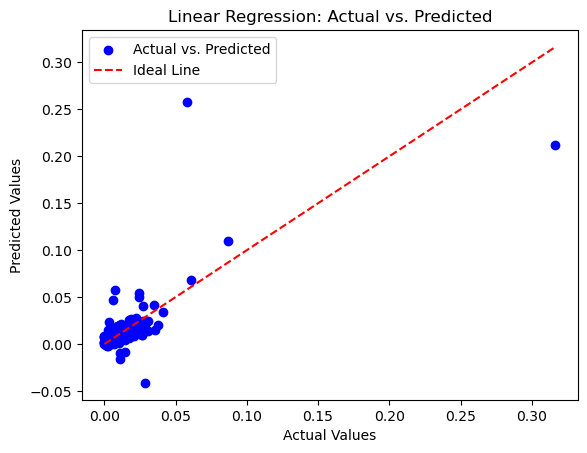

In [49]:
# Plotting the actual vs. predicted values
plt.scatter(y_test, y_pred_linear_reg, color='blue', label='Actual vs. Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label='Ideal Line')
plt.title('Linear Regression: Actual vs. Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

### let us reduce the dimensionality of the data using PCA and check

In [58]:
# Apply PCA with 2 components
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

linear_reg = LinearRegression()
linear_reg.fit(X_train_pca, y_train)

LinearRegression()

In [59]:
slope = linear_reg.coef_[0]
intercept = linear_reg.intercept_
print(f'y= {slope:.2f}x + {intercept:.2f}')

y= 0.02x + 0.01


In [60]:
y_pred_linear_reg_pca = linear_reg.predict(X_test_pca)

mse_pca = mean_squared_error(y_test, y_pred_linear_reg_pca)
r2_pca = r2_score(y_test, y_pred_linear_reg_pca)

print("Mean Squared Error with PCA:", mse_pca)
print("R-squared Value with PCA:", r2_pca)

Mean Squared Error with PCA: 0.00011204606763706235
R-squared Value with PCA: 0.13911650996563507


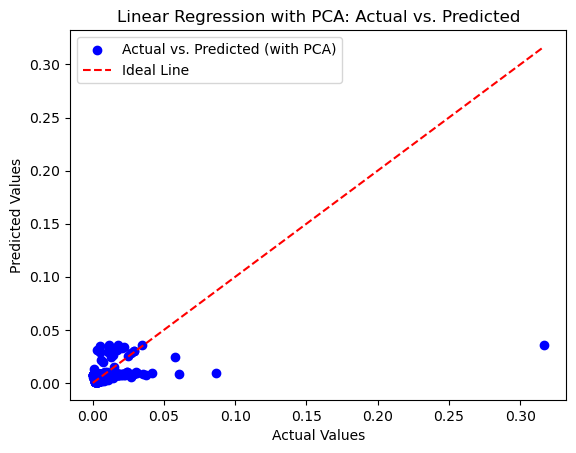

In [61]:
plt.scatter(y_test, y_pred_linear_reg_pca, color='blue', label='Actual vs. Predicted (with PCA)')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label='Ideal Line')
plt.title('Linear Regression with PCA: Actual vs. Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

### let us take two highly correlated columns and use them for Linear Regression

<AxesSubplot:>

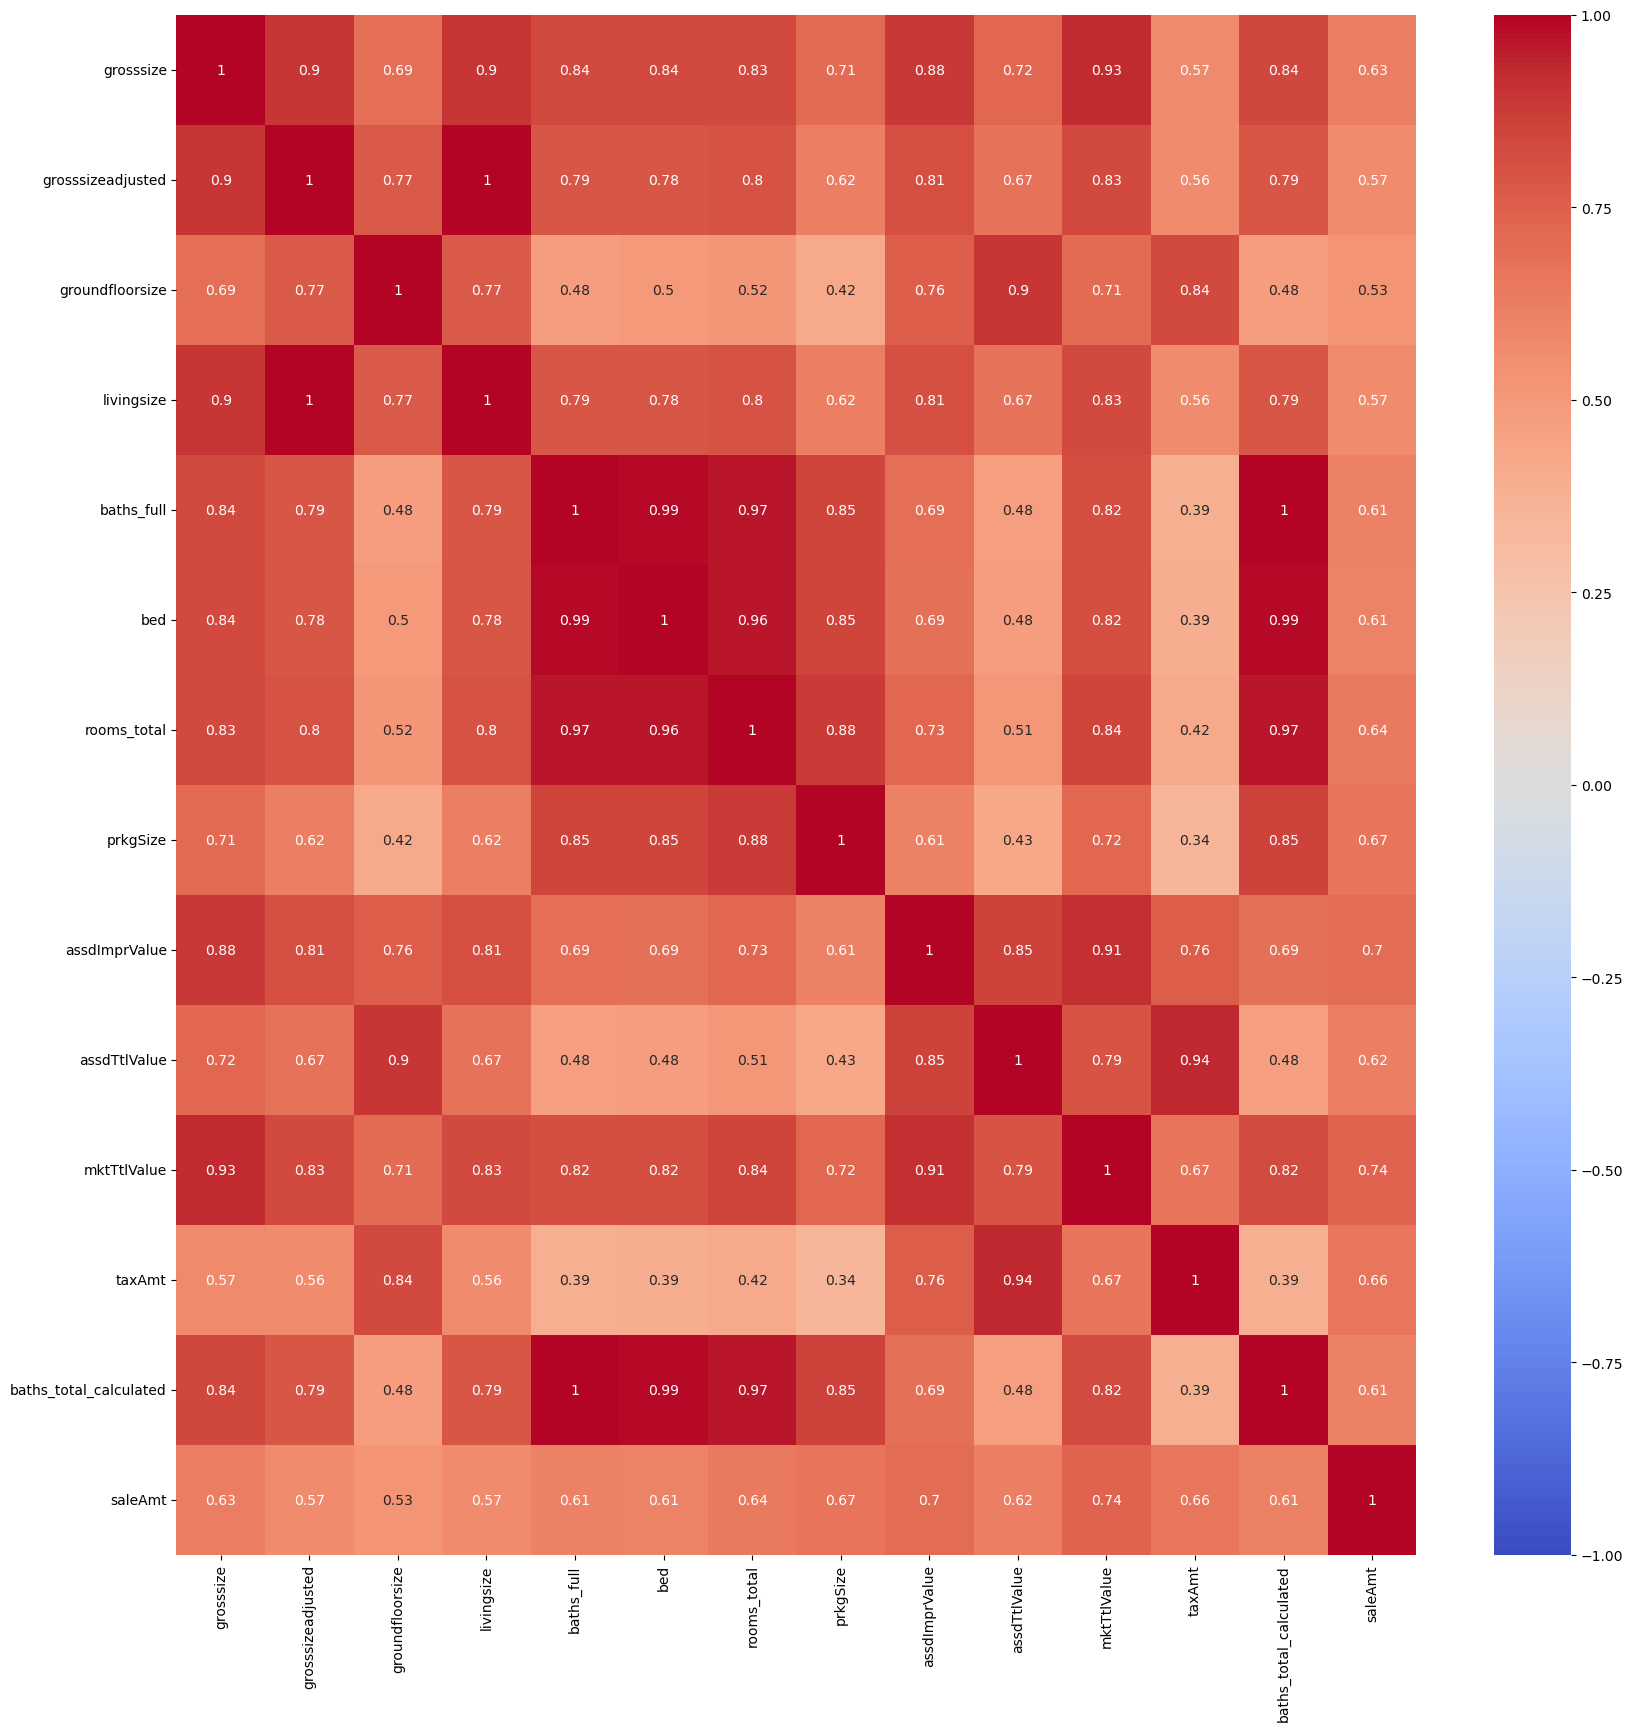

In [62]:
num_cols = [x for x in num_cols if x != 'saleAmt'] + ['saleAmt']
corr = property_df_normalized[num_cols].corr()

plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

### let us take grosssize and mktTtlValue columns

In [66]:
y = property_df_normalized["saleAmt"]
X = property_df_normalized[['grosssize', 'mktTtlValue']]

X.columns

Index(['grosssize', 'mktTtlValue'], dtype='object')

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [71]:
print(y_train.describe(include='all'))
print("\n")
print(X_train.describe(include='all'))
print("\n")
print(y_test.describe(include='all'))
print("\n")
print(X_test.describe(include='all'))

count    4117.000000
mean        0.007283
std         0.024588
min         0.000000
25%         0.003185
50%         0.004791
75%         0.007213
max         1.000000
Name: saleAmt, dtype: float64


         grosssize  mktTtlValue
count  4117.000000  4117.000000
mean      0.008051     0.011094
std       0.026422     0.029822
min       0.000000     0.000025
25%       0.002596     0.005216
50%       0.005186     0.008274
75%       0.008697     0.011451
max       1.000000     1.000000


count    1030.000000
mean        0.006570
std         0.011414
min         0.000000
25%         0.003017
50%         0.004690
75%         0.007469
max         0.316543
Name: saleAmt, dtype: float64


         grosssize  mktTtlValue
count  1030.000000  1030.000000
mean      0.006643     0.009904
std       0.008950     0.010567
min       0.000606     0.000000
25%       0.002555     0.005218
50%       0.004743     0.008198
75%       0.008314     0.011358
max       0.132651     0.210244


In [72]:
linear_reg = LinearRegression()
# Train the model on the training data
linear_reg.fit(X_train, y_train)

LinearRegression()

In [73]:
slope = linear_reg.coef_[0]
intercept = linear_reg.intercept_
print(f'y= {slope:.2f}x + {intercept:.2f}')

y= -0.46x + -0.00


In [74]:
# Make predictions on the testing data
y_pred_linear_reg = linear_reg.predict(X_test)

# Evaluate the performance of the model
mse = mean_squared_error(y_test, y_pred_linear_reg)
r2 = r2_score(y_test, y_pred_linear_reg)

print("Mean Squared Error:", mse)
print("R-squared Value:", r2)

Mean Squared Error: 9.289585738809382e-05
R-squared Value: 0.2862533098703437


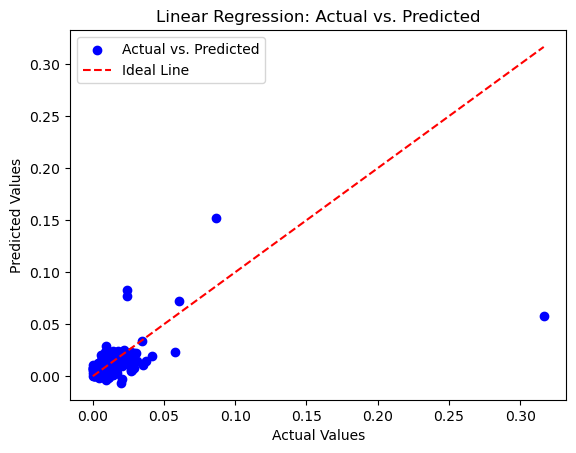

In [75]:
# Plotting the actual vs. predicted values
plt.scatter(y_test, y_pred_linear_reg, color='blue', label='Actual vs. Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label='Ideal Line')
plt.title('Linear Regression: Actual vs. Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()